- does lspi work?
    - linear yes...
    - rbf no...
- how does linear lspi behave according to D? 
    - only optimal - yes
    - noisy optimal
    - completely random
- how does rbf lspi behave according to D? 
    - only optimal
    - noisy optimal
    - completely random

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from env.simulator import * 
from util.plotting import *
from util.basis import *
from algo.fa import LinearQ3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [29]:
# linear basis func
p_linear = 3
q_linear = 3
phi_linear = get_linear_basis()
psi_linear = phi_linear

p_rbf = 100
q_rbf = 100
phi_rbf = get_rbf_basis(env, n_component=25)
psi_rbf = phi_rbf


precision = 0.1
eps = 0.001
gamma = 0.99
action_list = range(env.action_space.n)

/home/dhfromkorea/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Step 188 @ Episode 60/60 (-149.0)

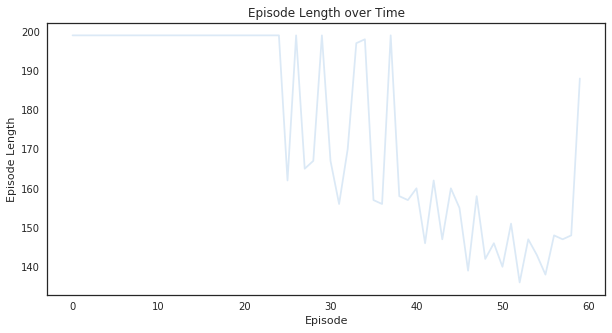

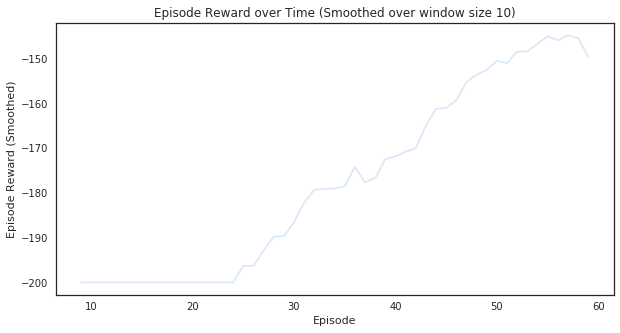

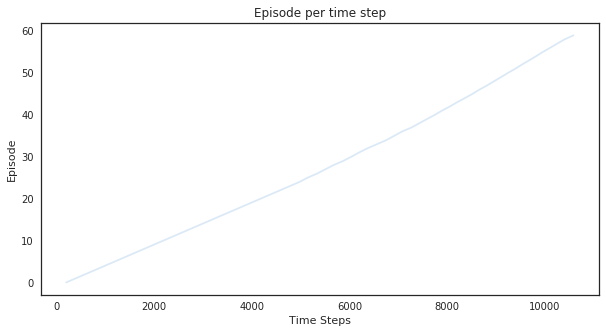

(<matplotlib.figure.Figure at 0x7f751fa94390>,
 <matplotlib.figure.Figure at 0x7f751fcab438>)

In [21]:
# one reason: basis function includes action (remove... but how?)
# swapping with the original code copy paste
# estimator update?
mdp_solver = LinearQ3(env=env,
                      phi=phi_rbf,
                      action_list=action_list,
                      n_episode=60,
                      epsilon=0.0,
                      epsilon_decay=1.0,
                      gamma=gamma)

pi_expert, stats = mdp_solver.solve()
#plotting.plot_cost_to_go_mountain_car(env, pi_expert._estimator)
plotting.plot_episode_stats(stats, smoothing_window=10)


In [22]:
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        return 0 if v <=0 else 2
pi = NearExpertPolicy()


#pi = RandomPolicy2(action_list)
D, stats = sim.simulate(pi=pi_expert, n_trial=1, n_episode=30, return_stats=True)

Step 150 @ Episode 30/30 (-152.0)

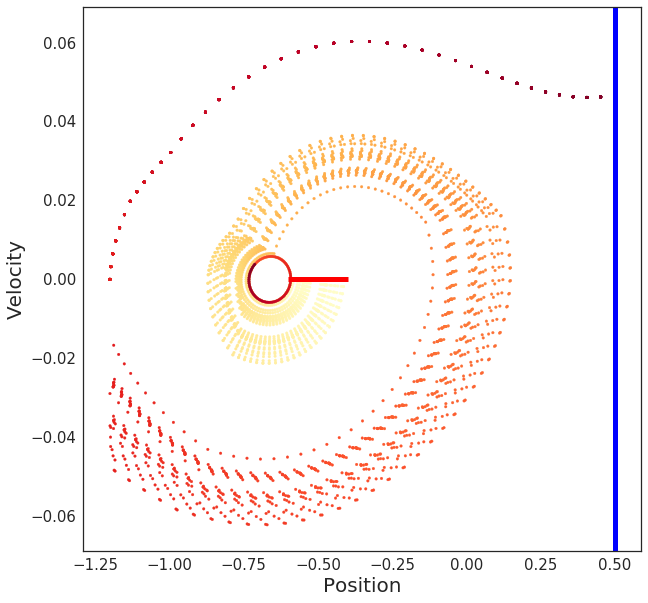

In [23]:
#plot_cost_to_go_mountain_car(env, pi_irl._estimator)
#plot_episode_stats(stZts, smoothing_window=5)
#dir(Simulator.to_matrix)
plot_trajectory_mountain_car(D)

In [24]:
def solve_mountain_car_linear(p, phi, gamma, precision, eps, D):
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=None)

    W = lspi.solve()
    return W
    
def solve_mountain_car_rbf(p, phi, gamma, precision, eps, D):  
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=None)

    W = lspi.solve()
    return W

D = Simulator.to_matrix(D)

In [25]:
print("batch data size {}".format(D.shape))
#W_linear = solve_mountain_car_linear(p_linear, phi_linear, gamma, precision, eps, D)
W_rbf = solve_mountain_car_rbf(p_rbf, phi_rbf, gamma, precision, eps, D)

batch data size (4690, 5)
Step 5 @ norm 310.84327019290123

KeyboardInterrupt: 

In [ ]:
#phi = phi_rbf
phi = phi_linear
pi_star = LinearQ2(action_list=action_list, phi=phi, W=W_linear)
D_star, stats = sim.simulate(pi=pi, n_trial=1, n_episode=50, return_stats=True)
plot_trajectory_mountain_car(D_star)